In [11]:
import pandas as pd
from copy import deepcopy
import optuna
from holidays.countries import US  
import plotly.graph_objects as go
import os
from neuralprophet import NeuralProphet
import joblib

In [12]:
stockdf = pd.read_csv('NFLX.csv')
print(f':{stockdf.shape}')
print(f':{stockdf.duplicated().sum()}')

:(5044, 7)
:0


In [13]:
stockdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


In [14]:
stockdf.describe().T.style.set_properties(**{"background-color": "#0F1F4C","color":"white","border": "1.5px solid white"})

In [15]:
stockdf.describe(include = 'object').T.style.set_properties(**{"background-color": "#0F1F4C","color":"white","border": "1.5px solid white"})

In [16]:
stockdf.isnull().sum().to_frame().T.style.set_properties(**{"background-color": "#0F1F4C","color":"white","border": "1.5px solid white"})

In [17]:
stockdf.head().style.set_properties(**{"background-color": "#0F1F4C","color":"white","border": "1.5px solid white"})

# Data visualization

In [18]:
stockdf['Date'] = pd.to_datetime(stockdf['Date'])
stockdf = stockdf.sort_values(by = 'Date')

In [27]:
from plotly.subplots import make_subplots
import plotly.io as pio

pio.renderers.default = "notebook"
pio.templates.default = "plotly_white"


In [28]:
print(stockdf.head())

fig1 = go.Figure(data=[go.Candlestick(x=stockdf['Date'],
                                     open=stockdf['Open'],
                                     high=stockdf['High'],
                                     low=stockdf['Low'],
                                     close=stockdf['Close'],
                                     increasing_line_color= '#FF0033',
                                     decreasing_line_color= '#009966')])

fig1.update_layout(title='Netflix Stock Price', yaxis_title='Price', template='plotly_white')


fig1.show('notebook')


        Date      Open      High       Low     Close  Adj Close     Volume
0 2002-05-23  1.156429  1.242857  1.145714  1.196429   1.196429  104790000
1 2002-05-24  1.214286  1.225000  1.197143  1.210000   1.210000   11104800
2 2002-05-28  1.213571  1.232143  1.157143  1.157143   1.157143    6609400
3 2002-05-29  1.164286  1.164286  1.085714  1.103571   1.103571    6757800
4 2002-05-30  1.107857  1.107857  1.071429  1.071429   1.071429   10154200


# The moving average of Netflix's closing price

In [29]:
# five days average
# rolling, pandas.core.series.Series
MA_5 = stockdf['Close'].rolling(window=5).mean()
# 10 days
MA_10 = stockdf['Close'].rolling(window=10).mean()
# 20 days
MA_20 = stockdf['Close'].rolling(window=20).mean()
# 30 days
MA_30 = stockdf['Close'].rolling(window=30).mean()
# plot
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=stockdf['Date'], y=stockdf['Close'], mode='lines', name='close', line_color='rgb(30, 56, 136)'))
fig2.add_trace(go.Scatter(x=stockdf['Date'], y=MA_5, mode='lines', name='MA5',line_color='rgb(71, 168, 189)'))
fig2.add_trace(
    go.Scatter(
        x=stockdf['Date'],
        y=MA_10,
        mode='lines',
        name='MA10',
        line_color='rgb(245, 230, 99)'))
fig2.add_trace(
    go.Scatter(
        x=stockdf['Date'],
        y=MA_20,
        mode='lines',
        name='MA20',
        line_color='rgb(255, 173, 105)'))
fig2.add_trace(
    go.Scatter(
        x=stockdf['Date'],
        y=MA_30,
        mode='lines',
        name='MA30',
        line_color='rgb(156, 56, 72)'))
fig2.update_layout(
    title='Moving Average of Closing Price',
    template='plotly_white')
fig2.show('notebook')


# Time Series Model Building and Prediction


In this section, the author will use NeuralProphet for training. NeuralProphet only supports two columns as input: timestamp and value. Therefore, here the author will first extract the "timestamp" and "closing price" for subsequent prediction.

In [30]:
closedf = stockdf[['Date','Close']]

closedf.columns = ['ds','y']

In [58]:
closedf

ds           y
0    2002-05-23    1.196429
1    2002-05-24    1.210000
2    2002-05-28    1.157143
3    2002-05-29    1.103571
4    2002-05-30    1.071429
...         ...         ...
5039 2022-05-27  195.190002
5040 2022-05-31  197.440002
5041 2022-06-01  192.910004
5042 2022-06-02  205.089996
5043 2022-06-03  198.979996

[5044 rows x 2 columns]

## baseline version

In [31]:
model = NeuralProphet()
model = model.add_country_holidays('US',mode="multiplicative")

In [32]:
df_train,df_valid = model.split_df(closedf,freq = 'D',valid_p = 0.15)
metrics = model.fit(df_train,freq = 'D',validation_df = df_valid,progress = 'plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.392% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.362% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 128


  0%|          | 0/141 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.11E-01, min: 1.18E+00


  0%|          | 0/141 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.68E-01, min: 1.37E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.03E-01
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/Users/hzlb/miniconda3/lib/python3.9/site-packages/neuralprophet/forecaster.py", line 2546, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
  0%|                                                                                                     | 0/128 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/hzlb/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:933: UserWarning:

Using a target size (torch.Size([756])) that is different to the input size (torch.Size([756, 1])). This will lik

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.362% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.362% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


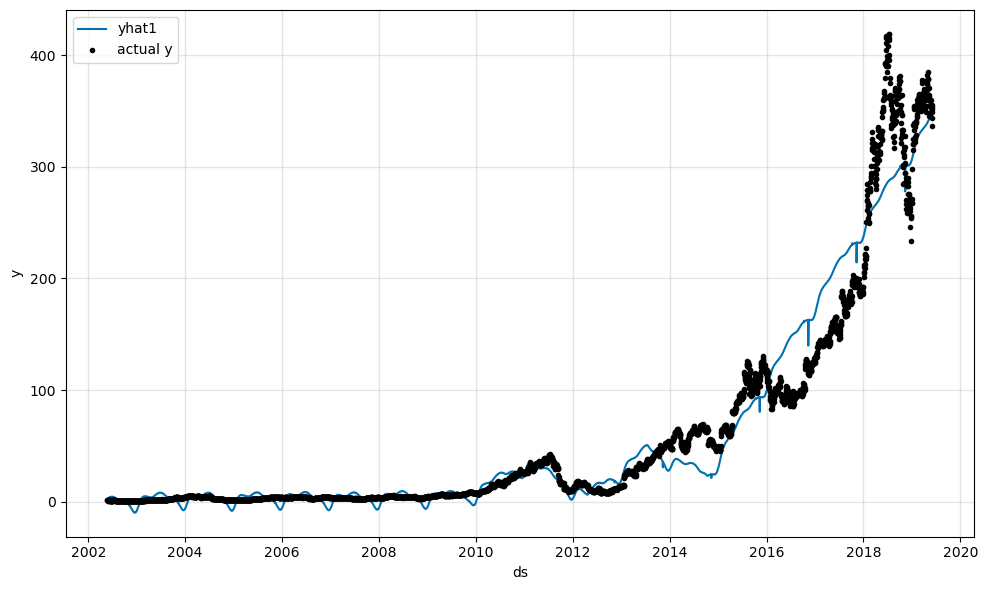

In [33]:
forcast_train = model.predict(df_train)
fig_train = model.plot(forcast_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.429% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


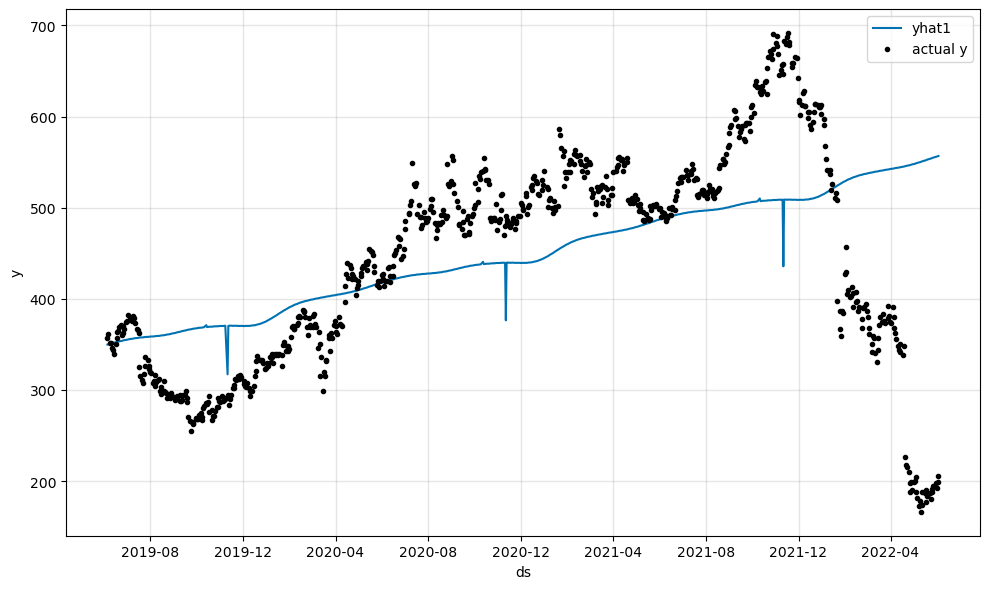

In [34]:
forcast_valid = model.predict(df_valid)
fig_valid = model.plot(forcast_valid)

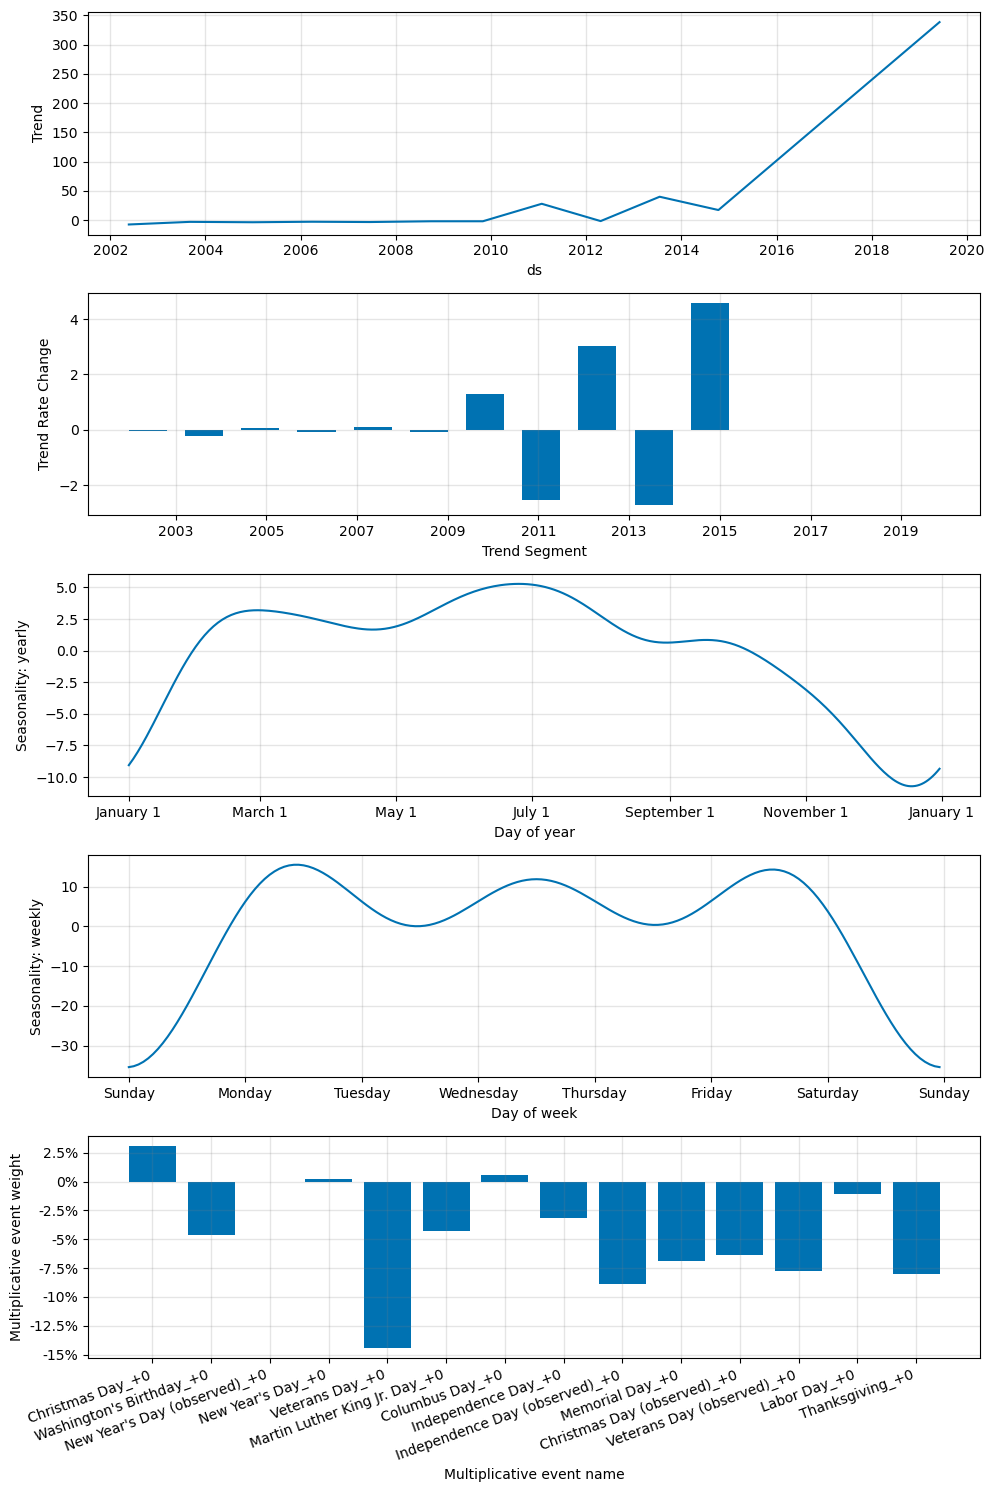

In [35]:
fig_param = model.plot_parameters()

## optuna adjust parameters version


In [46]:
from copy import deepcopy
import optuna

In [47]:
# NeuralProphet
default_para = {}

def create_nph(**para):
    temp_para = deepcopy(para)
    model = NeuralProphet(**temp_para)
    model = model.add_country_holidays('US',mode="multiplicative")
    return model

In [52]:

def objective(trial, df):
    params_grid = {'changepoints_range': trial.suggest_categorical('changepoints_range', [0.6,0.7,0.8, 0.9]), # 
                   'n_changepoints':trial.suggest_int('n_changepoints',5,20), 
                   'trend_reg':trial.suggest_loguniform('trend_reg',0.001,1), 
                   'learning_rate':trial.suggest_loguniform('learning_rate',0.001,1), 
                   'n_lags':trial.suggest_int('n_lags',1,5),
                   'num_hidden_layers':trial.suggest_int('num_hidden_layers',1,3),
                   'd_hidden':trial.suggest_int('d_hidden',2,32,2),
                   'seasonality_mode':trial.suggest_categorical('seasonality_mode',['additive','multiplicative']),
                   'seasonality_reg':trial.suggest_int('seasonality_reg',1,5),
                   }

    metrics = ['SmoothL1Loss', 'MAE','RMSE']
    metricsdf = pd.DataFrame(columns = metrics)

    temp_para = deepcopy(default_para)
    temp_para.update(params_grid)
    model = create_nph(**temp_para)
    folds = model.crossvalidation_split_df(df,freq = 'D',k = 5,fold_pct = 0.2,fold_overlap_pct = 0.5)
    for df_train,df_test in folds:
        model = create_nph(**temp_para)
        train = model.fit(df_train)
        test = model.test(df_test)
       
        metricsdf = pd.concat([metricsdf, test[metrics].iloc[-1]])
    out = metricsdf['MAE'].mean()
    return out

In [55]:
import logging

def objective(trial, df):
    try:
        params_grid = {
            'changepoints_range': trial.suggest_categorical('changepoints_range', [0.6, 0.7, 0.8, 0.9]),
            'n_changepoints': trial.suggest_int('n_changepoints', 5, 20),
            'trend_reg': trial.suggest_float('trend_reg', 0.001, 1, log=True),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 1, log=True),
            'n_lags': trial.suggest_int('n_lags', 1, 5),
            'num_hidden_layers': trial.suggest_int('num_hidden_layers', 1, 3),
            'd_hidden': trial.suggest_int('d_hidden', 2, 32, step=2),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'seasonality_reg': trial.suggest_int('seasonality_reg', 1, 5),
        }
        metrics = ['SmoothL1Loss', 'MAE', 'RMSE']
        temp_para = deepcopy(default_para)
        temp_para.update(params_grid)
        model = create_nph(**temp_para)
        folds = model.crossvalidation_split_df(df, freq='D', k=5, fold_pct=0.2, fold_overlap_pct=0.5)
        for df_train, df_test in folds:
            metricsdf = pd.DataFrame(columns=metrics)
            model = create_nph(**temp_para)
            train = model.fit(df_train)
            test = model.test(df_test)
            metricsdf = pd.concat([metricsdf, test[metrics].iloc[-1]])
        if metricsdf.empty:
            return float('inf')
        out = metricsdf['MAE'].mean()
        return out
    except Exception as e:
        logging.exception(f"Trial {trial.number} failed with error: {e}")
        return float('inf')

In [59]:
default_para

{}

In [56]:
%%time

study = optuna.create_study(direction = 'minimize',study_name = 'nph_tuning')

func = lambda trial:objective(trial,closedf)

study.optimize(func,n_trials = 5)
print(study.best_trial)
print(study.best_params)




[I 2024-06-04 10:02:18,178] A new study created in memory with name: nph_tuning
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.392% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 2273 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 2273 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 2273 NaN values in column y were auto-imputed.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.966% o

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142
Epoch[142/142]: 100%|█| 142/142 [01:00<00:00,  2.37it/s, SmoothL1Loss=0.00621, MAE=0.625, RMSE=0.86, Loss=0.00586, RegLoss=0.00057
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         1.494 15.096 17.998
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global a

INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 134
Epoch[134/134]: 100%|█| 134/134 [02:02<00:00,  1.09it/s, SmoothL1Loss=6.97e-5, MAE=0.224, RMSE=0.331, Loss=0.000137, RegLoss=7.72e
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.341 20.998 26.203
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_aut

Epoch[127/127]: 100%|█| 127/127 [01:04<00:00,  1.96it/s, SmoothL1Loss=4.65e-5, MAE=0.193, RMSE=0.386, Loss=4.45e-5, RegLoss=2.17e-
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.905 59.589 67.855
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.98% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet 

Epoch[122/122]: 100%|█| 122/122 [01:08<00:00,  1.77it/s, SmoothL1Loss=0.00248, MAE=3.86, RMSE=6.56, Loss=0.00248, RegLoss=0.00012]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.894 124.720 148.766
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralPro

ValueError: No trials are completed yet.

In [57]:
best_para = deepcopy(default_para)
best_para.update(study.best_params)
best_model = create_nph(**best_para)

ValueError: No trials are completed yet.

In [ ]:
df_train1,df_valid1 = best_model.split_df(closedf,freq = 'D',valid_p = 0.15)
best_metrics = best_model.fit(df_train1,freq = 'D',validation_df = df_valid1,progress = 'plot')

In [ ]:
forcast_train1 = best_model.predict(df_train1)
fig_train1 = best_model.plot(forcast_train1)

In [ ]:
forcast_valid1 = best_model.predict(df_valid1)
fig_valid1 = best_model.plot(forcast_valid1)

In [ ]:
fig_param1 = best_model.plot_parameters()